## Step 3: Image reconstruction

### Overview

In Step 2, we extracted spectrum in each bin. Now we reconstruct the response maps, make model response maps, and use them for image reconstruction.

**Tutorial Series**:
- [Step 1: Frame sorting](step1_frame_sorting.ipynb) 
- [Step 2: Spectral extraction](../visPLred/tutorials/step2_spectral_extraction.ipynb) 

---

### Process Workflow

1. **[Response map reconstruction](#sec1)**  
   From the `_spec.h5` files, generate response maps.

2. **[Response map modeling](#sec2)**  
   Make polynomial interpolation models of the response maps.

3. **[Centroid analysis](#3.-centroid-analysis)**  
   Use point source model to find centroid shifts across wavelengths.

4. **[Image reconstruction](#4.-image-reconstruction)**  
   Generate convolution matrices and reconstruct the intensity distribution


<a id='sec1'></a>
### 1. Response map reconstruction

Read `_spec.h5` files and make response maps.

The below script generates `_couplingmap.fits`.

In [1]:
import PLred.sort as sort

filename = 'remapped/remapped'
sort.make_responsemaps(filename, nfib = 38, nwav = 200, psfframe_shape = (40,40), nboot = 0)

Reading spectra


100%|██████████| 5/5 [00:00<00:00, 253.91it/s]


Reading PSF frames


100%|██████████| 5/5 [00:00<00:00, 333.94it/s]

remapped_couplingmap.fits saved in remapped/remapped_couplingmap.fits



/Users/yjkim/Documents/PLred2/PLred/PLred/sort.py:993: RuntimeWarning: Degrees of freedom <= 0 for slice.
  specs_var = np.nanvar(bootspecs, axis=0)
/Users/yjkim/Documents/PLred2/PLred/PLred/sort.py:994: RuntimeWarning: Degrees of freedom <= 0 for slice.
  normspecs_var = np.nanvar(normbootspecs, axis=0)


This fits file can be read through `CouplingMapModel` in `mapmodel.py`.

In [2]:
import PLred.mapmodel as mm

mapmodel = mm.CouplingMapModel(mapdata = 'remapped/remapped_couplingmap.fits', min_nframes = 0)

loading mapdata
masking data with less than 0 frames


Plot the coupling maps of wavelength index 100

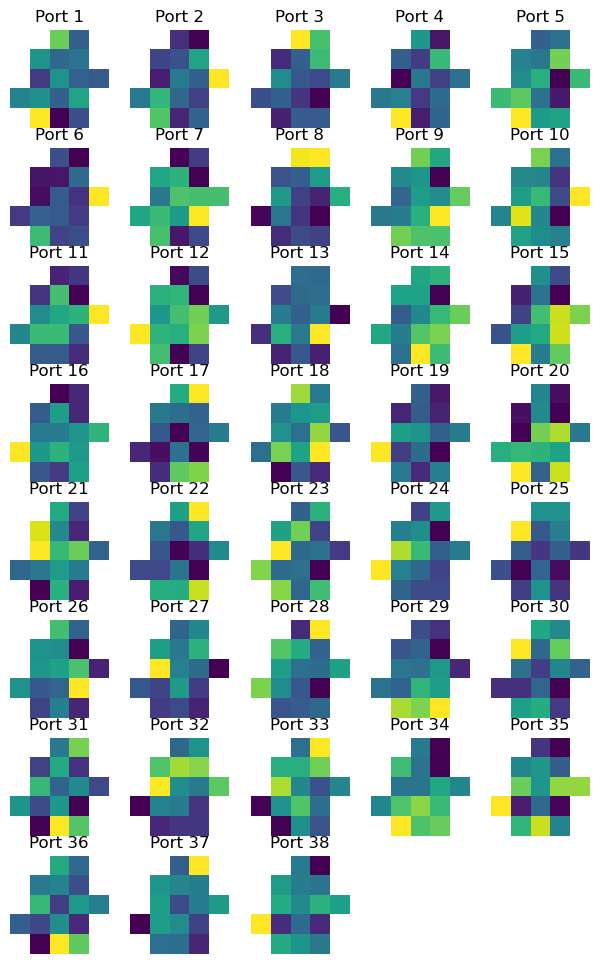

In [3]:
import matplotlib.pyplot as plt
import numpy as np

wavind = 100

fig, axs = plt.subplots(ncols=5, nrows=8, figsize=(5*1.5, 8*1.5), sharex=True, sharey=True)
axs = axs.flatten()
for i in range(38):
    axs[i].imshow(mapmodel.data[:,:,i,wavind])
    axs[i].axis('off')
    axs[i].set_title(f'Port {i+1}')
for ax in axs[38:]: 
    ax.axis('off')

We see some structures! However, this data is not enough for modeling the coupling maps (it was only 1 second observation!). 

For now on, we will use the response map file that was generated using 15 minutes of observation (`couplingmap_20240917.fits`).

<a id="sec2"></a>
### 2. Response map modeling

In [4]:
mapmodel = mm.CouplingMapModel(mapdata = 'reduced_data/couplingmap_20240917.fits', min_nframes = 5)


loading mapdata
masking data with less than 5 frames


The same plotting script as above.

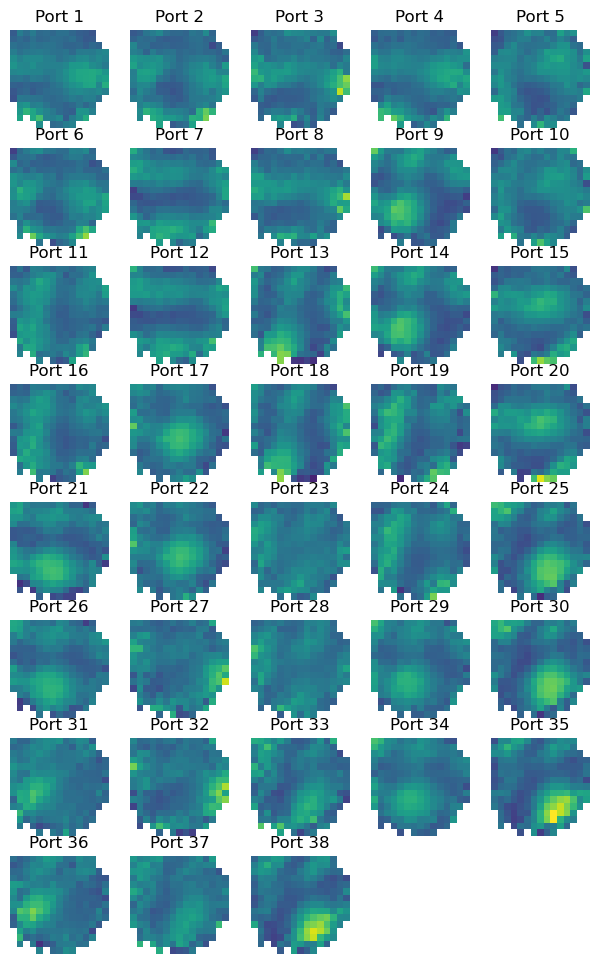

In [5]:
wavind = 100

fig, axs = plt.subplots(ncols=5, nrows=8, figsize=(5*1.5, 8*1.5), sharex=True, sharey=True)
axs = axs.flatten()
for i in range(38):
    axs[i].imshow(mapmodel.normdata[:,:,i,wavind], vmin=0, vmax=0.012)
    axs[i].axis('off')
    axs[i].set_title(f'Port {i+1}')
for ax in axs[38:]: 
    ax.axis('off')

Now we will model these maps with polynomial functions.

`CouplingMapModel.make_polynomial_model` does the modeling. First it fits the maps every wavelength with 2D polynomial functions, then fits the coefficients as a function of wavelength as 1D polynomial functions.

We want to find the wavelength index range to use for fitting (should exclude signal range) and to reconstruct (include signal range).

Inspect a few ix, iy, fibind values to see if we see any signals.

For this data, the signal was pretty big, so for some coordinates and fiber indices we see the rotation signature!

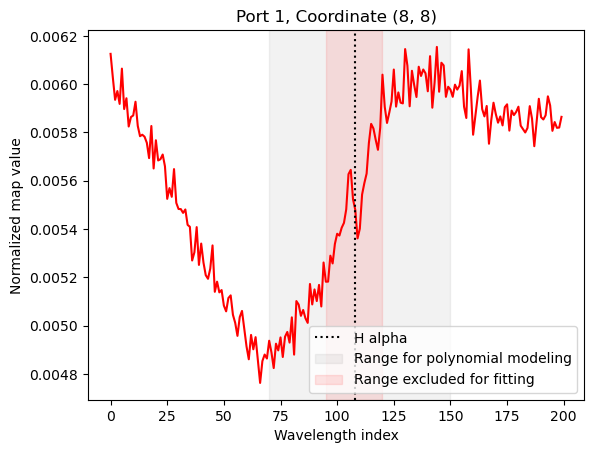

In [6]:
ix, iy = 7, 7 # coordinates in the map
fibind = 0 # fiber index
plt.plot(mapmodel.normdata[ix,iy,fibind], color='red')
plt.axvline(108, color='black', linestyle=':', label = 'H alpha')

plt.xlabel('Wavelength index')
plt.ylabel('Normalized map value')
plt.title(f'Port {fibind+1}, Coordinate ({ix+1}, {iy+1})')

wmin = 70
wmax = 150
fitmin = 95
fitmax = 120

wav_fitrange = np.r_[wmin:fitmin, fitmax:wmax]
wav_reconrange = np.r_[wmin:wmax]

plt.axvspan(wmin, wmax, color='gray', alpha=0.1, label='Range for polynomial modeling')
plt.axvspan(fitmin, fitmax, color='red', alpha=0.1, label='Range excluded for fitting')
plt.legend()
plt.show()

In [7]:


all_map_inputs, all_modeled_recons, all_modeled_coeffs, model_chi2 = \
    mapmodel.make_polynomial_model('reduced_data/polymodel_20240917', wav_fitrange, wav_reconrange,
    poly_deg_spatial=9, poly_deg_spectral=6)
        

100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


reduced_data/polymodel_20240917.fits saved


Now check the models!

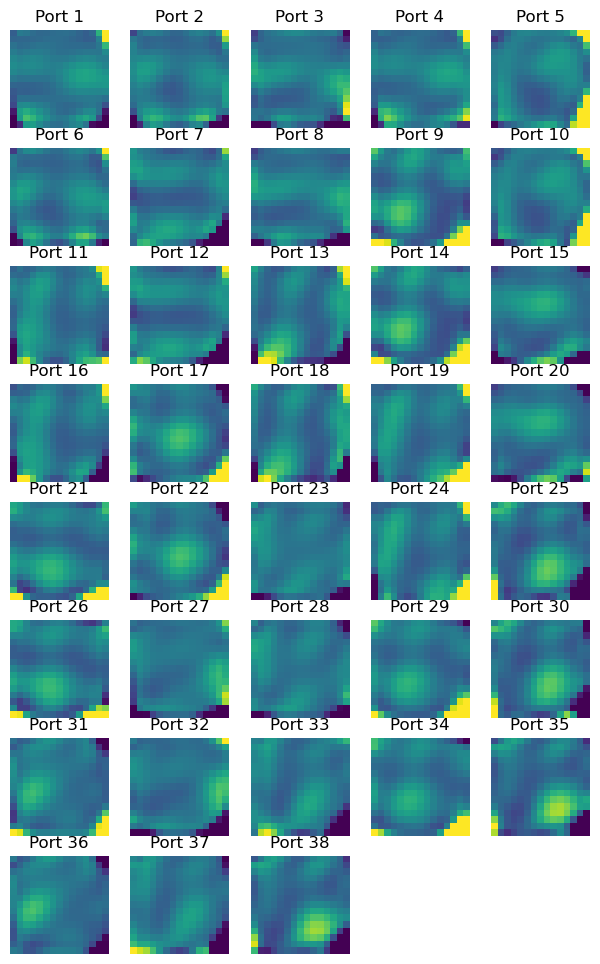

In [8]:
wavind = 100

fig, axs = plt.subplots(ncols=5, nrows=8, figsize=(5*1.5, 8*1.5), sharex=True, sharey=True)
axs = axs.flatten()
for i in range(38):
    axs[i].imshow(mapmodel.all_modeled_recons[:,:,i,wavind-wmin], vmin=0, vmax=0.012)
    axs[i].axis('off')
    axs[i].set_title(f'Port {i+1}')
for ax in axs[38:]: 
    ax.axis('off')

We can also check the models in wavelength space. (The overall level between the data and model can be a little bit off, but that is normal. It just reflects pixel-to-pixel variation in the response maps that comes from wavefront errors. But sometimes that can come from not enough polynomial orders. Try with a few different orders for the polynomial modeling)

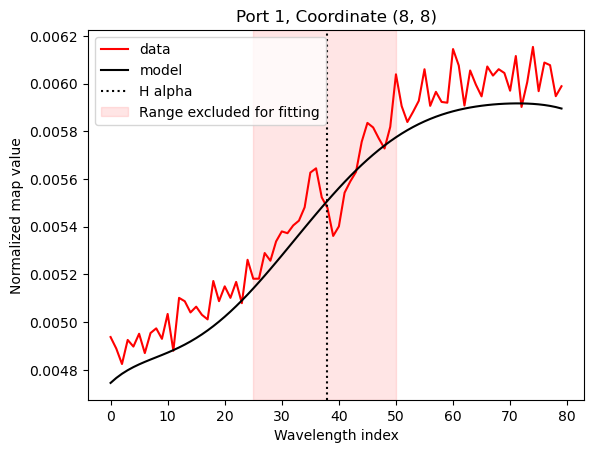

In [9]:
ix, iy = 7, 7 # coordinates in the map
fibind = 0 # fiber index
plt.plot(mapmodel.normdata[ix,iy,fibind, wav_reconrange], color='red', label='data')
plt.plot(mapmodel.all_modeled_recons[ix,iy,fibind], color='black', label='model')
plt.axvline(108 - wmin, color='black', linestyle=':', label = 'H alpha')
plt.axvspan(fitmin-wmin, fitmax-wmin, color='red', alpha=0.1, label='Range excluded for fitting')

plt.xlabel('Wavelength index')
plt.ylabel('Normalized map value')
plt.title(f'Port {fibind+1}, Coordinate ({ix+1}, {iy+1})')
plt.legend()
plt.show()

One cool way of checking the signals is by making an animation.

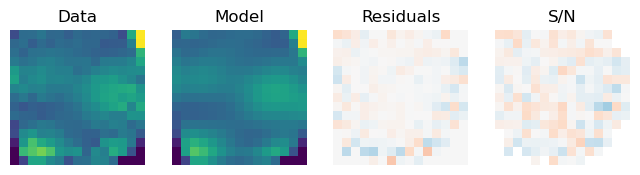

In [10]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axs = plt.subplots(ncols=4, figsize=(8,2), sharex=True, sharey=True)

fibind = 0
def animate(wavind):
    for ax in axs: ax.clear()
    axs[0].imshow(mapmodel.all_map_inputs[:,:,fibind,wavind], vmin=0, vmax=0.012)
    axs[1].imshow(mapmodel.all_modeled_recons[:,:,fibind,wavind], vmin=0, vmax=0.012)
    axs[2].imshow(mapmodel.all_map_inputs[:,:,fibind,wavind] - mapmodel.all_modeled_recons[:,:,fibind,wavind], vmin=-0.005, vmax=0.005, cmap='RdBu') 
    axs[3].imshow((all_map_inputs[:,:,fibind,wavind] - mapmodel.all_modeled_recons[:,:,fibind,wavind])/ np.sqrt(mapmodel.datanormvar[:,:,fibind,wavind]),
                  vmin=-10,vmax=10, cmap='RdBu')
    axs[0].set_title('Data')
    axs[1].set_title('Model')
    axs[2].set_title('Residuals')
    axs[3].set_title('S/N')
    for ax in axs: ax.axis('off')

ani = FuncAnimation(fig, animate, frames=np.arange(25,50), interval=100)
HTML(ani.to_jshtml())

Now we have model response maps. Let's use them to first estimate centroid shifts

### 3. Centroid analysis

Now that we made polynomial functions, we can compute the model maps for any (x, y) coordinate. This is implemented as the `CouplingMapModel.compute_vec` method. 

Re-define `mapmodel` by giving `polymodel_20240917.fits` as input

In [13]:
mapmodel = mm.CouplingMapModel(model = 'reduced_data/polymodel_20240917.fits')

loading model


In [15]:
xshift = 1.2 # shift in x (mas)
yshift = 0 # shift in y (mas)
wavind = 40
fibind = 1

# trim the edges of the map to avoid edge effects in shifted maps (polynomial model diverges outside the map)
n_trim = 1
trimmed_map_shape = (mapmodel.map_n - 2*n_trim, mapmodel.map_n - 2*n_trim)


# reference map (no shift)
model0 = mapmodel.compute_vec(wavind, fibind, 0, 0, n_trim = n_trim).reshape(trimmed_map_shape)

# compute the model with the given (x, y) shift
model = mapmodel.compute_vec(wavind, fibind, xshift, yshift, n_trim = n_trim).reshape(trimmed_map_shape)

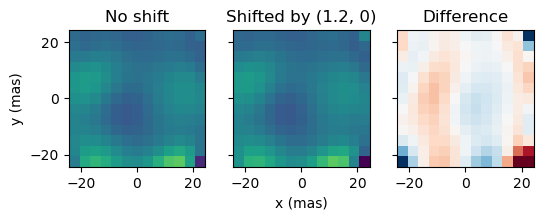

In [16]:
fig, axs = plt.subplots(ncols=3, figsize=(6,2), sharex=True, sharey=True)
axs[0].imshow(model0, vmin=0, vmax=0.012, extent = (min(mapmodel.pos_mas), max(mapmodel.pos_mas), 
                                                      min(mapmodel.pos_mas), max(mapmodel.pos_mas)))
axs[1].imshow(model, vmin=0, vmax=0.012, extent = (min(mapmodel.pos_mas), max(mapmodel.pos_mas), 
                                                      min(mapmodel.pos_mas), max(mapmodel.pos_mas)))
axs[2].imshow(model - model0, vmin=-0.001, vmax=0.001, cmap='RdBu', extent = (min(mapmodel.pos_mas), max(mapmodel.pos_mas), 
                                                      min(mapmodel.pos_mas), max(mapmodel.pos_mas)))

axs[0].set_title('No shift')
axs[1].set_title(f'Shifted by ({xshift}, {yshift})')
axs[2].set_title('Difference')
axs[0].set_ylabel('y (mas)')
axs[1].set_xlabel('x (mas)')
plt.show()

We can model the shifted response maps, which represent point source shift. Then we can solve $\chi^2$ minimization problem to find how much shift best describes the data.

In [17]:
from scipy.optimize import minimize

def chi2_model_point(param, wavind = 0, fibinds=np.arange(38)):
    chi2 = 0
    (x,y) = param
    ndfs = 0
    for fibind in fibinds:
        model = mapmodel.compute_vec(wavind, fibind, x, y, n_trim=n_trim).reshape(trimmed_map_shape)
        data = mapmodel.normdata[n_trim:-n_trim,n_trim:-n_trim,fibind,wavind]
        datavar = mapmodel.datanormvar[n_trim:-n_trim,n_trim:-n_trim,fibind,wavind]

        chi2 += np.nansum((model-data)**2 / datavar)
        ndfs += np.sum(np.isfinite(datavar))
    ndfs -= len(param)
    return chi2/ndfs

In [18]:
results = []
for wavind in np.arange(25, 50):
    opt = minimize(chi2_model_point, x0=[0,0], args=(wavind,np.arange(38)))
    print(wavind, opt.x)
    results.append(opt.x)

25 [-0.04323311 -0.02906747]
26 [-0.1200919   0.06379094]
27 [-0.00090119 -0.01551653]
28 [ 0.01896449 -0.06547822]
29 [ 0.052038   -0.06413161]
30 [-0.01740117 -0.0527888 ]
31 [-0.08018876  0.0515848 ]
32 [-0.01426587 -0.0489046 ]
33 [ 0.12331747 -0.19138293]
34 [ 0.27158695 -0.33613829]
35 [ 0.41825453 -0.58060597]
36 [ 0.43411713 -0.70212345]
37 [ 0.17320869 -0.6135013 ]
38 [-0.40247438  0.11979128]
39 [-0.57192641  0.68730805]
40 [-0.45194482  0.64712546]
41 [-0.34109427  0.46649611]
42 [-0.22314998  0.22308451]
43 [-0.09630909  0.12988909]
44 [-0.04439436  0.02371019]
45 [-0.00915377 -0.02868077]
46 [-0.07374716  0.03403944]
47 [-0.04606227  0.00444132]
48 [-0.03205799 -0.00038025]
49 [-0.01805601 -0.02961785]


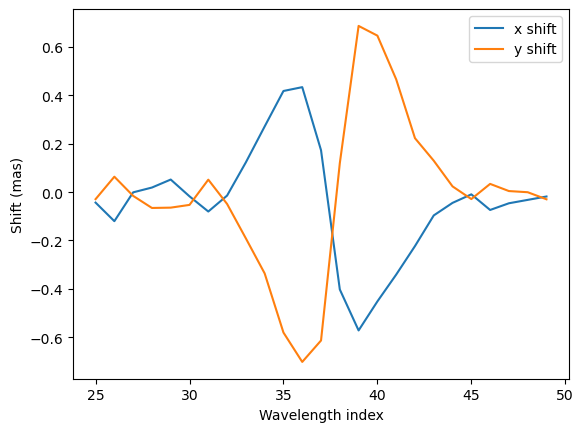

In [19]:
plt.plot(np.arange(25, 50), np.array(results)[:,0], label='x shift')
plt.plot(np.arange(25, 50), np.array(results)[:,1], label='y shift')
plt.xlabel('Wavelength index')
plt.ylabel('Shift (mas)')
plt.legend()
plt.show()

The centroid shifts along x and y directions are recovered!

### 4. Image reconstruction

Now we try nonparametric image reconstruction.
We will compute the response maps in a grid of (x, y) shifts, and make a giant convolution matrix from them.

**(Observed response map) = (Image) ⊛ (Reference response map)**

Here **⊛** is convolution. Let's say the image is defined on a **m×m** grid and observed response map of one of the fibers and at one wavelength has **n×n** resolution.


The convolution can be represented as a matrix multiplication.

**(flattened response map) = (convolution matrix) (flattened image)**

Where:
- **Flattened image**: m²-vector  
- **Flattened response map**: n²-vector  
- **Convolution matrix**: (n², m²)-matrix


Since we have **38 fibers**, we can extend these:
- **Flattened response map** → **n² × 38**-vector
- **Convolution matrix** → **(n² × 38, m²)**-matrix


To compute the convolution matrix, do

In [21]:
import PLred.fit as fit

image_fov = 12
image_ngrid = 15

fitter = fit.PLMapFit(model_file = 'reduced_data/polymodel_20240917.fits',
                      image_ngrid = image_ngrid,
                      image_fov = image_fov,
                      n_trim = 1)

wavind = 36
fitter.make_matrix(wavind, fiber_inds = np.arange(38))

loading model


225it [00:04, 54.77it/s]

all the fiber indices are used. saving the matrix to mat_full


Now we can reconstruct the image

In [22]:
fitter.prepare_data(fiber_inds= np.arange(38))

# hyperparameters
ini_temp            = 1e3
tau                 = 3e5
gamma               = 10000 
n_elements          = 50
target_chi2         = 1.0

fitter.store_hyperparams(ini_temp, tau, gamma, n_elements, target_chi2)

preparing data for specind 36


  0%|          | 0/1000 [00:00<?, ?it/s]

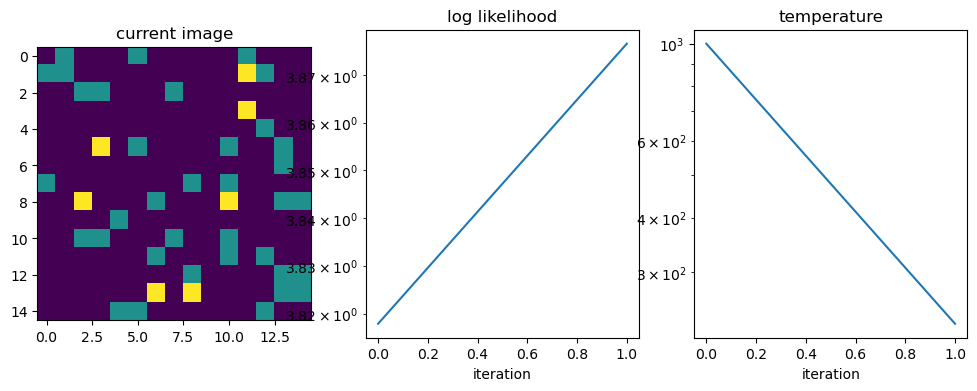

 49%|████▉     | 492/1000 [00:01<00:01, 372.35it/s]

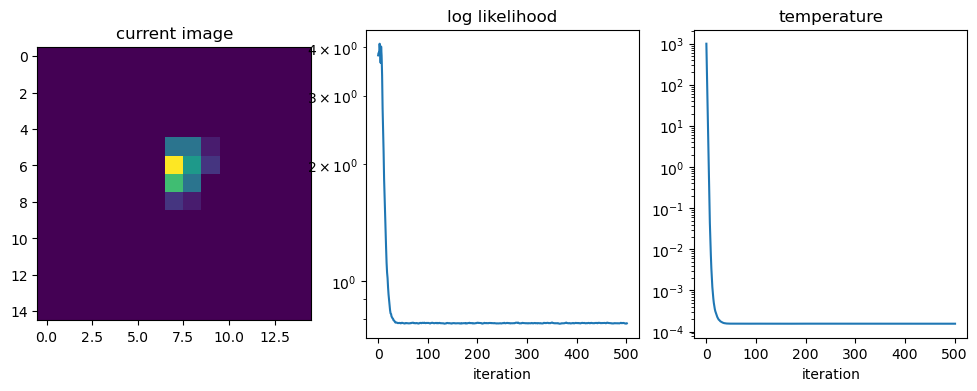

100%|██████████| 1000/1000 [00:03<00:00, 281.45it/s]


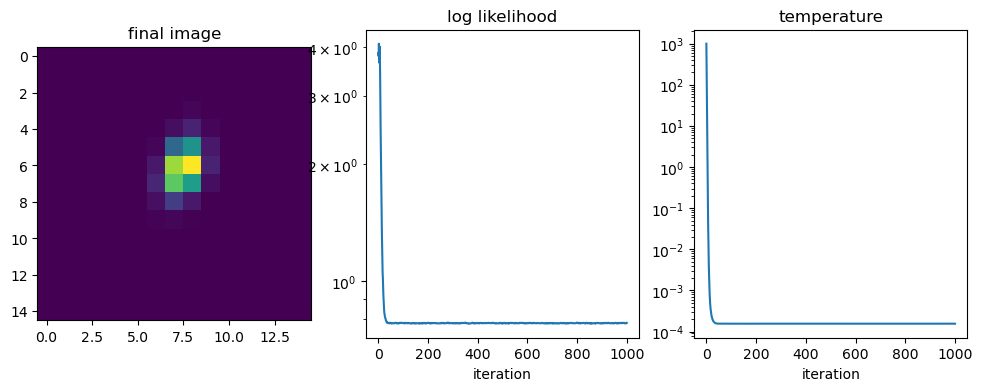

Done
Final chi2 1.5606528645363642


In [23]:
rc = fitter.run(small_to_random_ratio = 1,
                prior_type = 'uniform',
                burn_in_iter = 500,
                niter = 1000,
                plot_every = 500,
                plot=True)

View the image

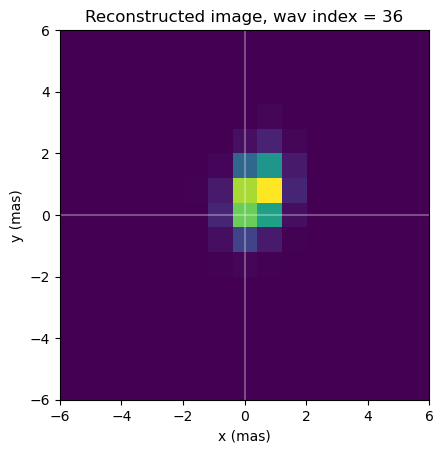

In [24]:
from PLred.imgrecon import locs2image

im = locs2image(rc.post_locs, rc.axis_len).copy()
plt.imshow(im, extent = (-image_fov/2, image_fov/2, -image_fov/2, image_fov/2),
           origin='upper')
plt.axvline(0, color='white',alpha=0.3)
plt.axhline(0, color='white',alpha=0.3)
plt.xlabel('x (mas)')
plt.ylabel('y (mas)')
plt.title('Reconstructed image, wav index = {}'.format(wavind))
plt.show()

Let's try another wavelength

In [25]:
wavind = 38
fitter.make_matrix(wavind, fiber_inds = np.arange(38))

225it [00:04, 53.70it/s]

all the fiber indices are used. saving the matrix to mat_full


preparing data for specind 38


  0%|          | 0/1000 [00:00<?, ?it/s]

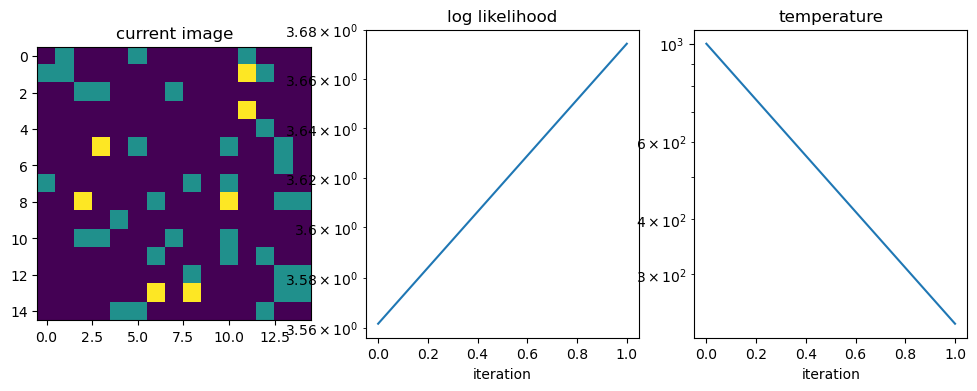

 47%|████▋     | 471/1000 [00:01<00:01, 337.29it/s]

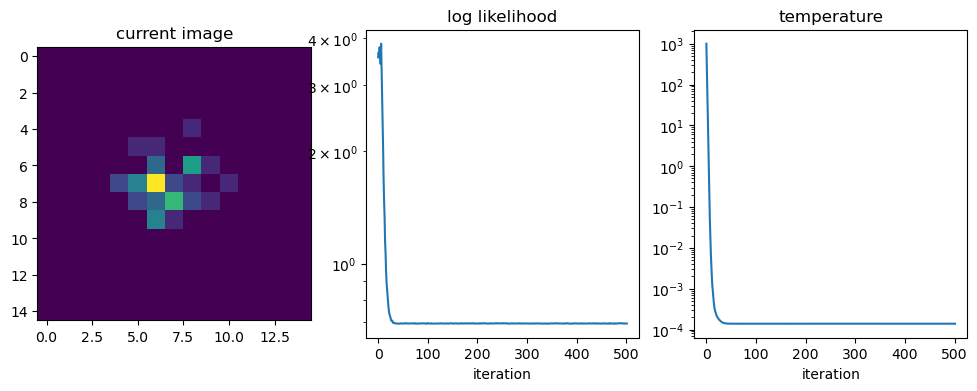

100%|██████████| 1000/1000 [00:03<00:00, 258.82it/s]


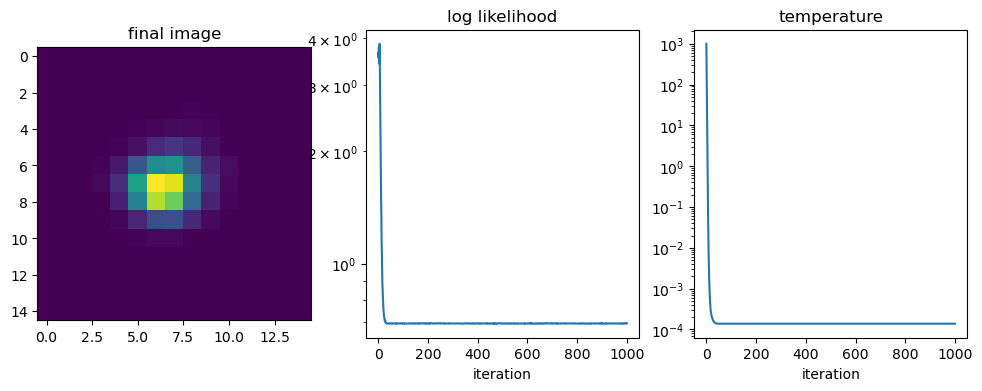

Done
Final chi2 1.3875709165834167


In [26]:
fitter.prepare_data(fiber_inds= np.arange(38))
fitter.store_hyperparams(ini_temp, tau, gamma, n_elements, target_chi2)
rc = fitter.run(small_to_random_ratio = 1,
                prior_type = 'uniform',
                burn_in_iter = 500,
                niter = 1000,
                plot_every = 500,
                plot=True)

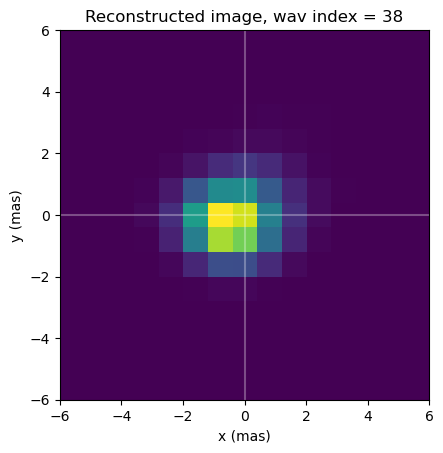

In [27]:

im = locs2image(rc.post_locs, rc.axis_len).copy()
plt.imshow(im, extent = (-image_fov/2, image_fov/2, -image_fov/2, image_fov/2),
           origin='upper')
plt.axvline(0, color='white',alpha=0.3)
plt.axhline(0, color='white',alpha=0.3)
plt.xlabel('x (mas)')
plt.ylabel('y (mas)')
plt.title('Reconstructed image, wav index = {}'.format(wavind))
plt.show()